# Real-world Temporal Network Simulations
Here we will illustrate how the DelayBufferNetwork framework can be used to build temporal networks on real-world data. We use the Thiers13 data set here, from sociopatterns.org (http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/)

Keep in mind that this uses an older version of DelayBufferNetwork. Using the updated framework is recommended but it will not work in the same way.

Note that this network is more connected than the network build on the Workplace15 data, meaning that this notebook takes much longer to execute. 

First, load in the data (which was preprocessed from the original contact representation format (t: {agent_1, agent_2, ...}) to event format (i, j, t, event_id))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from DelayBufferNetwork import DelayBufferNetwork

/Users/lschoonheid/Dropbox/Docs/UvA/Master Computational Science/period 3/Complex System Simulation/CLS-7/.css/lib/python3.11/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# Download the Thiers13 dataset from sociopatterns.org
# extract data
data = pd.read_csv("real_world_data/HighSchool2013_proximity_net.csv", delim_whitespace=True, header=None)
data.head()

,0,1,2,3,4
0,1385982020,454,640,MP,MP
1,1385982020,1,939,2BIO3,2BIO3
2,1385982020,185,258,PC*,PC*
3,1385982020,55,170,2BIO3,2BIO3
4,1385982020,9,453,PC,PC


In [3]:
# Save to .npy
np.save("Thiers13/Thiers13.npy", data.values)
event_data = np.load("Thiers13/Thiers13.npy", allow_pickle=True)
event_data

array([[1385982020, 454, 640, 'MP', 'MP'],
       [1385982020, 1, 939, '2BIO3', '2BIO3'],
       [1385982020, 185, 258, 'PC*', 'PC*'],
       ...,
       [1386345580, 272, 939, '2BIO3', '2BIO3'],
       [1386345580, 311, 496, 'PC', 'PC'],
       [1386345580, 120, 285, 'PC', 'PC']], dtype=object)

In [4]:
df = pd.DataFrame(event_data, columns=["t", "i", "j", "weight", "event_id"])
df['event_id'] = df.index.astype(int)
df.head(5)


,t,i,j,weight,event_id
0,1385982020,454,640,MP,0
1,1385982020,1,939,2BIO3,1
2,1385982020,185,258,PC*,2
3,1385982020,55,170,2BIO3,3
4,1385982020,9,453,PC,4


In [5]:
# Create a dictionary to map the old agent IDs to the new agent IDs
agent_id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(df['i'].unique()))}
agent_id_mapj = {old_id: new_id for new_id, old_id in enumerate(sorted(df['j'].unique()))}
t_map = {old_id: new_id for new_id, old_id in enumerate(sorted(df['t'].unique()))}
weight_map = {old_id: 1 for new_id, old_id in enumerate(sorted(df['weight']))}

In [6]:
# Map the old agent IDs to the new agent IDs in the DataFrame
df['i'] = df['i'].map(agent_id_map)
df['j'] = df['j'].map(agent_id_mapj)
df['t'] = df['t'].map(t_map)
df['weight'] = df['weight'].map(weight_map)
df

,t,i,j,weight,event_id
0,0,162,202,1,0
1,0,0,265,1,1
2,0,68,93,1,2
3,0,20,49,1,3
4,0,3,151,1,4
...,...,...,...,...,...
188503,7373,44,105,1,188503
188504,7374,22,48,1,188504
188505,7374,108,265,1,188505
188506,7374,119,169,1,188506


Build the Network by initializing a DBN


In [7]:
dbn = DelayBufferNetwork(nettype = "wd", from_df=df, uniform_time_range=True, dont_build_df=True, del_df=True)
# save it in case you need it later
dbn.save_event_arrays("Thiers13/1")
dbn.save_event_dict("Thiers13/1")

First, do a practice run

In [8]:
def sim(b):
    dbn = DelayBufferNetwork(load=True, path="Thiers13/1")
    dbn.add_delay(expon_distr_bool=True, tau = 1, using_event_dict=True)
    dbn.add_event_buffer(buffer=b, uniform_buffer_bool=True, using_event_dict=True)
    dbn.process_delays_fast_arrays(interact_with_topology=False)
    event_delays = dbn.event_current_delay_array
    agent_delays = np.mean(dbn.agent_delays, axis=1)
    return event_delays, agent_delays

In [9]:
result = sim(b=1)

Let's see the results of this single run.

Text(0, 0.5, 'Mean delay per node')

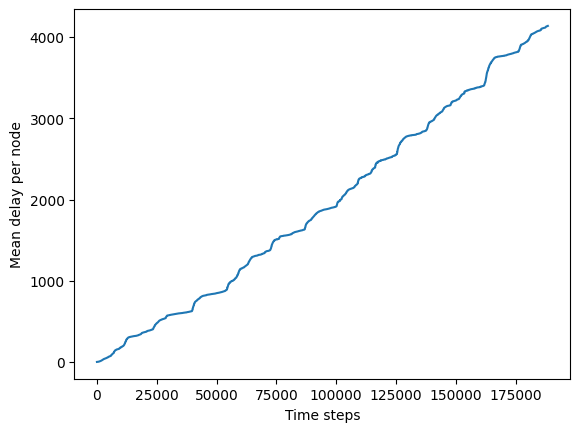

In [10]:
plt.plot(range(len(result[1])), result[1])
plt.xlabel("Time steps")
plt.ylabel("Mean delay per node")

To create a $v$ versus $B$ graph, we must do more simulations.

Let's set our simulation settings

In [11]:
buffers = np.arange(0, 5, 0.5)

Simulate! (it roughly takes the same time as the single simulation / number of threads * 50)

In [12]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=4)(delayed(sim)(buffers[i]) for i in range(len(buffers)))

/Users/lschoonheid/Dropbox/Docs/UvA/Master Computational Science/period 3/Complex System Simulation/CLS-7/.css/lib/python3.11/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/Users/lschoonheid/Dropbox/Docs/UvA/Master Computational Science/period 3/Complex System Simulation/CLS-7/.css/lib/python3.11/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/Users/lschoonheid/Dropbox/Docs/UvA/Master Computational Science/period 3/Complex System Simulation/CLS-7/.css/lib/python3.11/site-packages/nilear

Reformat the results to give us $V$

In [13]:
delays_prop = []
for i in range(len(results)):
    delays_prop.append(results[i][1][1:] - results[i][1][:-1])

Now we can plot a simple $v$ versus $B$ graph

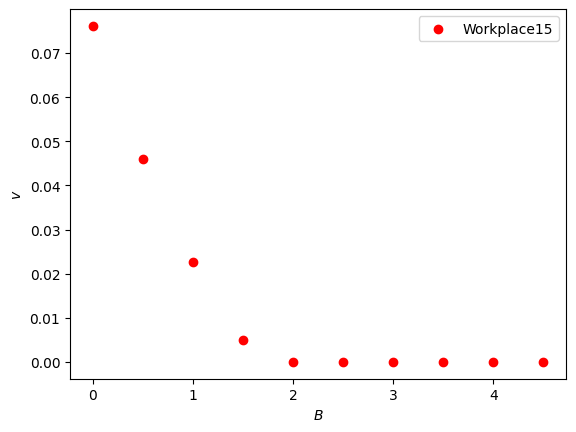

In [14]:
for i, b in enumerate(buffers):
    plt.scatter(b, np.mean(delays_prop[i]), c="r")
    
plt.legend(["Workplace15"])

plt.xlabel(r"$B$")
plt.ylabel(r"$v$")

plt.show()